# Simple analysis example of HWP using SO HK data 
SO HK data reading and writing tips: <br>
https://so3g.readthedocs.io/en/latest/hk.html#writing-hk-data

## Import libraries
Import SO related libraries: so3g, g3thwp <br>
If you see any error after this, check the name of kernel. The kernel name must be soenv_20220401 at UTokyo workstation.

In [1]:
import sys
import os
import numpy as np
import datetime as dt
import time as tm
import scipy.interpolate
import matplotlib.pyplot as plt
import scipy as sp
import glob

from g3thwp import G3tHWP
import so3g
from sotodlib import core, flags, tod_ops, sim_flags
from sotodlib.io.load_smurf import load_file
from sotodlib.tod_ops import fourier_filter, rfft, detrend_tod
import sotodlib.tod_ops.filters as filters

## `G3tHWP`
package to provide HWP angle and approximated speed from SO HK data </br>

### Load SO HK data with g3 file name list

In [5]:
tsat_g3 = glob.glob('/mnt/SOdata/pton-tsat/hk/16395/1639599416.g3')
tsat_g3_path = ['/mnt/SOdata/pton-tsat/hk/' + tsat_g3[i].split('/')[5] for i in range(len(tsat_g3))]
tsat_g3_file = [tsat_g3[i].split('/')[6] for i in range(len(tsat_g3))]

In [6]:
hwp = G3tHWP()
for f in range(len(tsat_g3_path)):
    load_data = hwp.load_file(tsat_g3_path[f], tsat_g3_file[f])
    solved = hwp.analyze(load_data)
    hwp.write_solution(solved,'/hdd/disk3/ysakurai/data/output_g3/' + tsat_g3_file[f])

In [9]:
solved['hwp_rate'][np.where(solved['locked'])]

array([0.6580408 , 0.6580408 , 0.6580408 , ..., 0.76666377, 0.76666377,
       0.76666377])

### Load SO HK data with time range

In [45]:
start, end = 1643342329, 1643342929 # 2Hz rotation data from TSAT (Pton)
archive_path = '/mnt/so1/data/pton-tsat/hk/' # path to HK data archive
hwp = G3tHWP()
data = hwp.load_data(start, end, archive_path)

In [46]:
start, end = 1643340368.424739, 1643340969.269591 #spinup data from TSAT (Pton)
hwp = G3tHWP()
data2 = hwp.load_data(start, end, archive_path)

### Analyze loaded HWP parameters and return angles
Return  dict{fast_time, angle, slow_time, stable, locked, hwp_rate}
* fast_time: IRIG synched timing (~2kHz) 
* angle (float): IRIG synched HWP angle in radian
* slow_time: time list of slow block
* stable (flag): if non-zero, indicates the HWP spin state is known. i.e. it is either spinning at a measurable rate, or stationary.  When this flag is non-zero, the hwp_rate field can be taken at face value.
* locked (flag): if non-zero, indicates the HWP is spinning and the position solution is working. 
* hwp_rate (float): the "approximate" HWP spin rate, with sign, in revs / second.  Use placeholder value of 0 for cases when not "stable".

In [47]:
solved = hwp.analyze(data)

### Plot hwp speed & angle

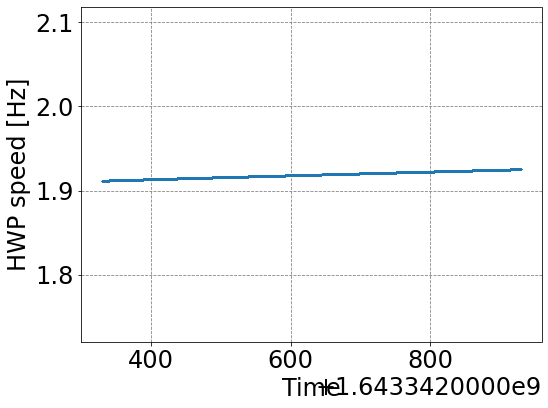

In [48]:
plt.figure(figsize=(8,6))
plt.xlabel('Time')
plt.ylabel('HWP speed [Hz]')
idx = np.where(solved['locked'])
plt.plot(solved['slow_time'][idx],solved['hwp_rate'][idx],'.', markersize=0.1)
plt.ylim(solved['hwp_rate'][idx].min()*0.9,solved['hwp_rate'][idx].max()*1.1)
plt.show()

In [6]:
solved2 = hwp.analyze(data2)

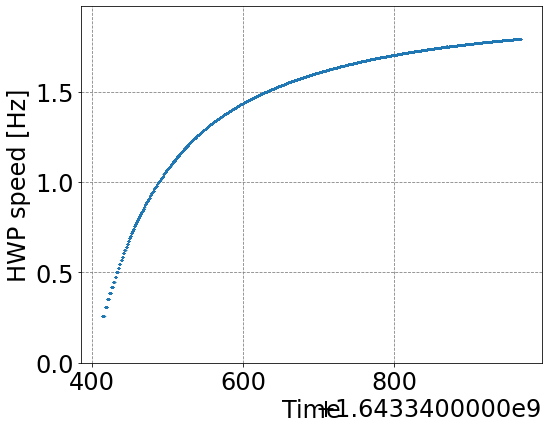

In [7]:
plt.figure(figsize=(8,6))
plt.xlabel('Time')
plt.ylabel('HWP speed [Hz]')
idx = np.where(solved2['locked'])
plt.plot(solved2['slow_time'][idx],solved2['hwp_rate'][idx],'.', markersize=0.1)
plt.ylim(0,solved2['hwp_rate'][idx].max()*1.1)
plt.show()

In [8]:
print(solved)

{'fast_time': array([1.64334233e+09, 1.64334233e+09, 1.64334233e+09, ...,
       1.64334293e+09, 1.64334293e+09, 1.64334293e+09]), 'angle': array([0.65587636, 0.66138793, 0.66689949, ..., 1.67551608, 1.68102765,
       1.68653921]), 'slow_time': array([1.64334037e+09, 1.64334038e+09, 1.64334039e+09, ...,
       1.64334293e+09, 1.64334293e+09, 1.64334293e+09]), 'stable': array([False, False, False, ...,  True,  True,  True]), 'locked': array([False, False, False, ..., False, False, False]), 'hwp_rate': array([0., 0., 0., ..., 0., 0., 0.])}


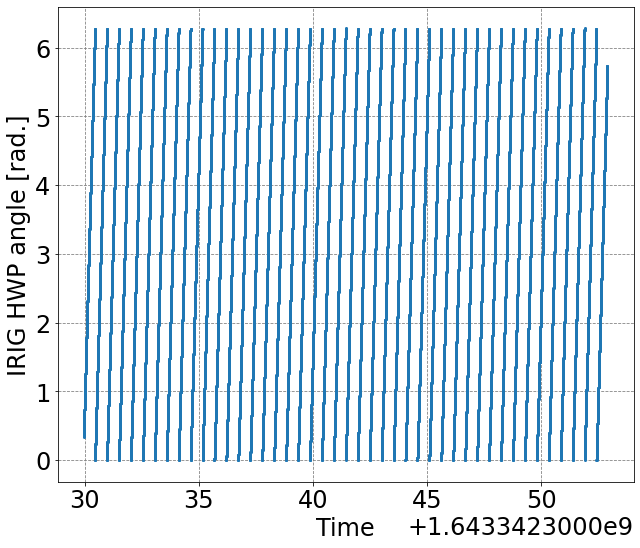

In [9]:
n = 50000
plt.figure(figsize=(10,8))
plt.xlabel('Time')
plt.ylabel('IRIG HWP angle [rad.]')
idx = np.where(solved['locked'])
plt.plot(solved['fast_time'][idx][:n], solved['angle'][idx][:n], '.',markersize=4)
plt.show()

### Output HWP angle g3 file with SO HK data format (optional)

In [10]:
hwp.write_solution(solved,'output.g3')

### Laod output angle g3 file

In [11]:
scanner = so3g.hk.HKArchiveScanner()
filename = 'output.g3'
scanner.process_file(filename)
arc = scanner.finalize()
print(arc.get_data()[0].keys())

dict_keys(['hwp.hwp_rate', 'hwp.locked', 'hwp.stable', 'hwp.hwp_angle'])


In [12]:
fields = ['hwp.hwp_angle', 'hwp.locked', 'hwp.stable','hwp.hwp_rate']

In [13]:
output_data = arc.simple(fields)
fast_time = output_data[0][0]
angle = output_data[0][1]
slow_time = output_data[1][0]
locked = output_data[1][1]
stable = output_data[2][1]
hwp_rate = output_data[3][1]

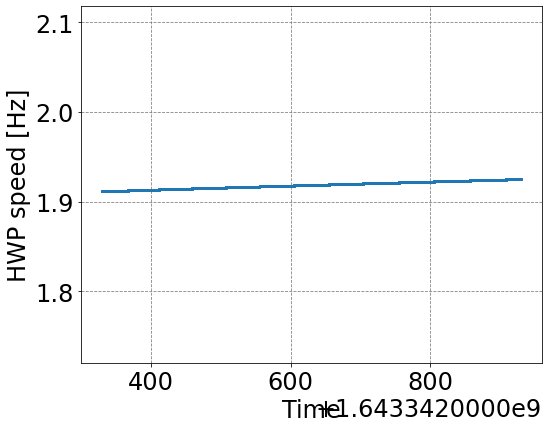

In [14]:
plt.figure(figsize=(8,6))
plt.xlabel('Time')
plt.ylabel('HWP speed [Hz]')
idx = np.where(solved['locked'])
plt.plot(slow_time[idx],hwp_rate[idx],'.',markersize=1)
plt.ylim(hwp_rate[idx].min()*0.9,hwp_rate[idx].max()*1.1)
plt.show()

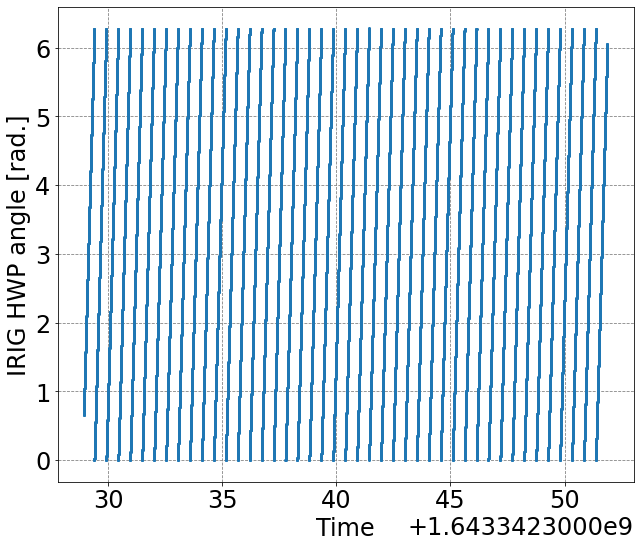

In [15]:
n = 50000
plt.figure(figsize=(10,8))
plt.xlabel('Time')
plt.ylabel('IRIG HWP angle [rad.]')
idx = np.where(solved['locked'])
plt.plot(output_data[0][0][:n],output_data[0][1][:n],'.',markersize=4)
plt.show()

## Example of detector timestream + HWP analysis

### load timestream

**HWP spinning at around 2Hz** <br>
/pton-rd/timestreams/16433/crate1slot4/1643342329_000.g3 <br>
/pton-rd/timestreams/16433/crate1slot4/1643342329_001.g3

In [16]:
#archive_path = '/path/to/data/timestream/'
archive_path = '/mnt/so1/data/pton-rd/timestreams/16433/crate1slot4'
aman = load_file([   
    archive_path + '/1643342329_000.g3',
    archive_path + '/1643342329_001.g3',
])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.46s/it]


In [17]:
phase_to_pA = 9e6/(2*np.pi) #design value of uMUX calculated from mutual inductance of TES and SQUID loop
aman.signal *= phase_to_pA

### Llinear interpolation between IRIG and SMuRF timing

In [18]:
import scipy
hwp_angle = scipy.interpolate.interp1d(solved['fast_time'], solved['angle'], kind='linear',fill_value='extrapolate')(aman.timestamps) % (2*np.pi)

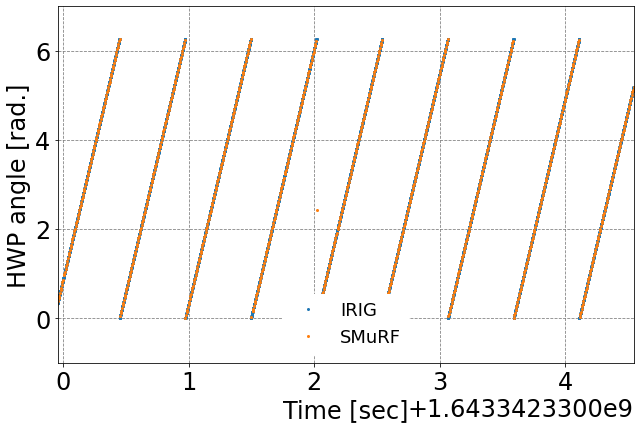

In [19]:
n = 10000
plt.figure(figsize=(10,6))
plt.xlabel('Time [sec]')
plt.ylabel('HWP angle [rad.]')
idx = np.where(solved['locked'])
plt.plot(solved['fast_time'][idx], solved['angle'][idx], '.',markersize=4, label='IRIG')
plt.plot(aman.timestamps, hwp_angle, '.', markersize=4, label ='SMuRF')
plt.xlim(solved['fast_time'][idx][0],solved['fast_time'][idx][n])
plt.ylim(-1,7)
plt.legend()
plt.show()

### HWP Syncrhnous Signal

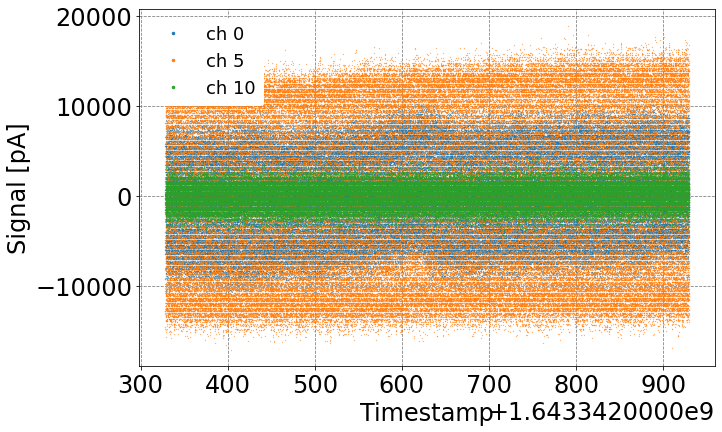

In [21]:
plt.figure(figsize=(10,6))
plt.xlabel('Timestamp')
plt.ylabel('Signal [pA]')
for i in [0,5,10]:
    plt.plot(aman.timestamps,aman.signal[i] - aman.signal[i].mean(),".", markersize=0.5, label='ch ' + str(i))
plt.legend(markerscale=10)
plt.show()

In [22]:
signal = aman.signal[5]
bins = 128
hwpss = np.histogram(hwp_angle, bins=bins, range=[0, 2*np.pi], weights=signal)[0] / np.histogram(hwp_angle, bins=bins, range=[0, 2*np.pi])[0]

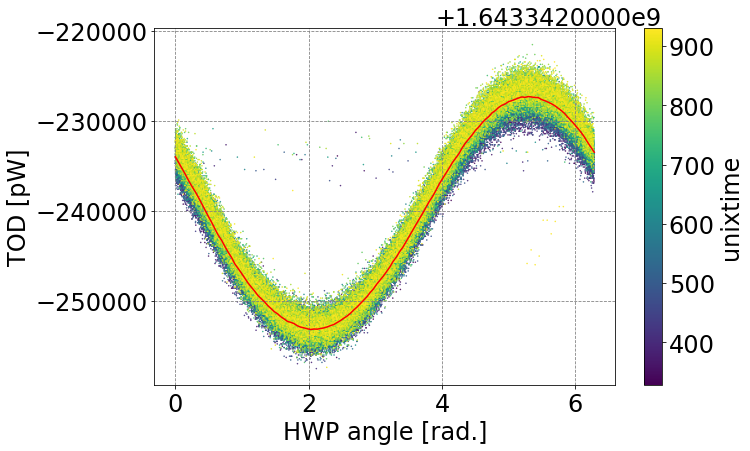

In [24]:
plt.figure(figsize=(10,6))
plt.ylabel('TOD [pW]')
plt.xlabel('HWP angle [rad.]')
mappable=plt.scatter(hwp_angle, signal, c=aman.timestamps, marker='.', s=1)
plt.plot(np.linspace(0, 2*np.pi, bins),hwpss,"r-")
plt.rcParams['axes.grid'] = False
cbar = plt.colorbar()
cbar.set_label('unixtime')
plt.rcParams['axes.grid'] = True
plt.show()

In [25]:
ffts, freqs = rfft(aman, resize=None)
tsamp = np.median(np.diff(aman.timestamps))
norm_fact =  np.sqrt(2)*(1.0/tsamp)*np.sum(np.abs(np.hanning(aman.samps.count))**2)

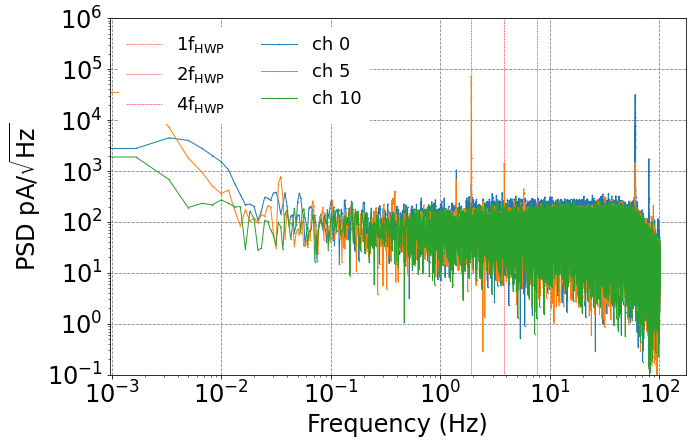

In [26]:
plt.figure(figsize=(10,6))
plt.ylabel('PSD $\mathrm{pA / \sqrt{Hz}}$')
plt.xlabel('Frequency (Hz)')

fhwp = hwp_rate.mean()
plt.vlines(1*fhwp,0,1e11,color='r',lw=0.5,linestyle='--',label=r'1f$_{\mathrm{HWP}}$')
plt.vlines(2*fhwp,0,1e11,color='r',lw=0.5,linestyle='--',label=r'2f$_{\mathrm{HWP}}$')
plt.vlines(4*fhwp,0,1e11,color='r',lw=0.5,linestyle='--',label=r'4f$_{\mathrm{HWP}}$')

#for i in range(aman.dets.count):
for i in [0,5,10]:
    psd = np.sqrt(np.abs(ffts[i])**2/norm_fact)
    plt.loglog(freqs, psd, '.-', markersize=1, lw=1, label='ch ' + str(i))
plt.ylim(1e-1,1e6)
plt.legend(loc=2,ncol=2)
plt.show()

### Demodulation demonstration

__To do work__ <br>
* demodulation input AxisManeger as argument, compatible with sotodlib format
* need to average sampling??

In [131]:
import g3thwp
import importlib
importlib.reload(g3thwp)
from g3thwp import G3tHWP
hwp = G3tHWP()

ch = 10
signal = aman.signal[ch]
time = aman.timestamps
fs = 200.
signal_demod = hwp.demod(signal, time, fs, hwp_angle,  bpf_width=0.5)

In [132]:
fft, freq = hwp.psd(signal, fs)
fft_demod, freq = hwp.psd(signal_demod, fs)
mask_lpf = np.where(freq<0.5)

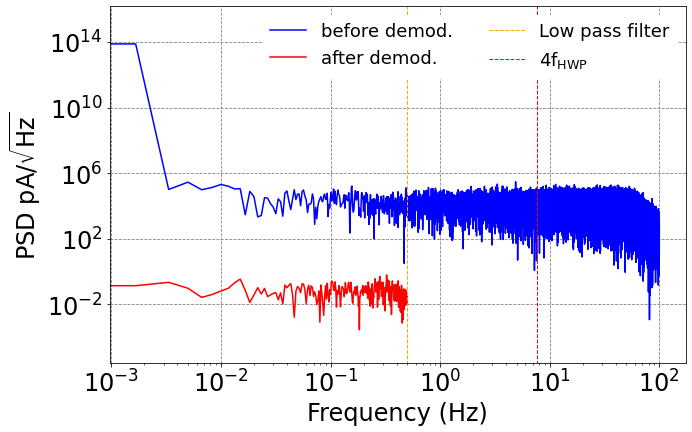

In [133]:
fig = plt.figure(figsize=(10,6))
plt.ylabel('PSD $\mathrm{pA / \sqrt{Hz}}$')
plt.xlabel('Frequency (Hz)')
plt.loglog(freq, fft, "-b", label="before demod.")
plt.loglog(freq[mask_lpf], fft_demod[mask_lpf], "-r", label="after demod.")
ymax = fft.max() * 1e2
ymin = fft_demod[mask_lpf].min()*1e-2
plt.vlines(0.5,0,ymax,color='orange',lw=1,linestyle='--',label=r'Low pass filter')
plt.vlines(4*fhwp,0,ymax,color='r',lw=1,linestyle='--',label=r'4f$_{\mathrm{HWP}}$')
plt.ylim(ymin,ymax)
plt.legend(ncol=2,fontsize=18)
plt.show()

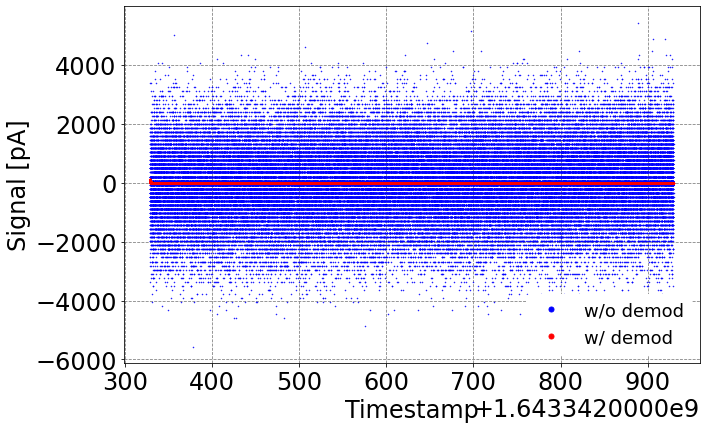

In [138]:
fig = plt.figure(figsize=(10,6))
plt.ylabel('Signal [pA]')
plt.xlabel('Timestamp')
mask = np.zeros_like(aman.timestamps, np.bool_)
mask[:] = 1
plt.plot(aman.timestamps[mask], signal[mask] - signal[mask].mean(),  '.b', label='w/o demod', markersize=1)
plt.plot(aman.timestamps[mask], signal_demod[mask] - signal_demod[mask].mean(),  '.r', label='w/ demod', markersize=1)
plt.legend(markerscale=10)
plt.show()